In [3]:
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

In [4]:
df1 = pd.read_csv('uber_carpoolservice.csv')
df2 = pd.read_csv('lyft_carpoolservice.csv')
df1.head()

,Unnamed: 0,date_time,date,day,uber_display_name,uber_distance,uber_duration,end_latitude,end_location,end_longitude,...,main_temp,main_temp_max,main_temp_min,uber_product_id,start_latitude,start_location,start_longitude,time,weather,uber_category
0,0,2/25/2018 0:00,25-Feb-18,Sunday,POOL,2.83,540,42.363046,Charles River Canoe & Kayak,-71.082354,...,39.52,44.6,33.8,997acbb5-e102-41e1-b155-9df7de0a73f2,42.361652,Urban AdvenTours,-71.052037,0:00:04,Clear,Carpool Service
1,6,2/25/2018 0:01,25-Feb-18,Sunday,POOL,1.50,420,42.355373,Boston Common,-71.065750,...,39.52,44.6,33.8,997acbb5-e102-41e1-b155-9df7de0a73f2,42.347060,Kings Dining & Entertainment - Boston Back Bay,-71.085650,0:01:03,Clear,Carpool Service
2,12,2/25/2018 0:02,25-Feb-18,Sunday,POOL,1.45,360,42.363520,Innercity Weightlifting,-71.082860,...,39.47,44.6,33.8,997acbb5-e102-41e1-b155-9df7de0a73f2,42.377843,Achieve Fitness,-71.091881,0:02:03,Clear,Carpool Service
3,18,2/25/2018 0:03,25-Feb-18,Sunday,POOL,2.26,540,42.370460,Broadway Bicycle School,-71.103520,...,39.79,44.6,33.8,997acbb5-e102-41e1-b155-9df7de0a73f2,42.348503,Commonwealth Avenue Mall,-71.094223,0:03:04,Clear,Carpool Service
4,24,2/25/2018 0:04,25-Feb-18,Sunday,POOL,2.47,540,42.352040,Btone Fitness - Back Bay,-71.072590,...,38.95,44.6,33.8,997acbb5-e102-41e1-b155-9df7de0a73f2,42.365095,Prana Power Yoga,-71.102730,0:04:03,Clear,Carpool Service


In [5]:
df1['uber_price_estimate'] = (df1['uber_max_estimate'] + df1['uber_min_estimate'])/2
df2['lyft_price_estimate'] = (df2['lyft_max_estimate'] + df2['lyft_min_estimate'])/2

In [6]:
df1.columns

Index(['Unnamed: 0', 'date_time', 'date', 'day', 'uber_display_name',
       'uber_distance', 'uber_duration', 'end_latitude', 'end_location',
       'end_longitude', 'uber_max_estimate', 'uber_min_estimate', 'main_temp',
       'main_temp_max', 'main_temp_min', 'uber_product_id', 'start_latitude',
       'start_location', 'start_longitude', 'time', 'weather', 'uber_category',
       'uber_price_estimate'],
      dtype='object')

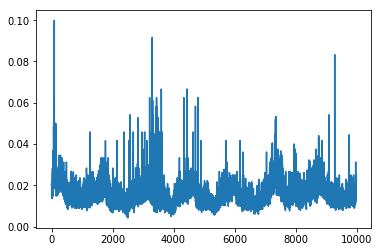

In [7]:
df1['uber_price_per_second'] = df1.uber_price_estimate/df1.uber_duration
df1['uber_price_per_second'].plot()

In [8]:
TS = np.array(df1['uber_price_per_second'])
num_periods = 100
f_horizon = 1

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 100, 1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 100, 1)
print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)

99
(99, 100, 1)
[[[0.02037037]
  [0.01904762]
  [0.02083333]
  [0.01851852]
  [0.01851852]
  [0.02083333]
  [0.01818182]
  [0.01833333]
  [0.02142857]
  [0.01851852]
  [0.01851852]
  [0.01904762]
  [0.01388889]
  [0.02083333]
  [0.01851852]
  [0.01759259]
  [0.02142857]
  [0.01818182]
  [0.02142857]
  [0.01527778]
  [0.01833333]
  [0.01458333]
  [0.01666667]
  [0.01770833]
  [0.01666667]
  [0.01354167]
  [0.01666667]
  [0.025     ]
  [0.025     ]
  [0.028125  ]
  [0.01818182]
  [0.01805556]
  [0.02407407]
  [0.0219697 ]
  [0.01785714]
  [0.01875   ]
  [0.01851852]
  [0.02583333]
  [0.02083333]
  [0.01818182]
  [0.01875   ]
  [0.02685185]
  [0.02083333]
  [0.02083333]
  [0.0202381 ]
  [0.01904762]
  [0.02261905]
  [0.03690476]
  [0.02380952]
  [0.03257576]
  [0.02291667]
  [0.03095238]
  [0.0202381 ]
  [0.01833333]
  [0.03055556]
  [0.02361111]
  [0.01481481]
  [0.0212963 ]
  [0.01851852]
  [0.03055556]
  [0.03181818]
  [0.01794872]
  [0.03055556]
  [0.02619048]
  [0.02222222]
  [0.0183

In [9]:
def test_data(series, forecast, num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 100, 1)
    testY = TS[-(num_periods):].reshape(-1, 100, 1)
    return testX, testY

X_test, Y_test = test_data(TS, f_horizon, num_periods)
print(X_test.shape)
print(X_test)

(1, 100, 1)
[[[0.01481481]
  [0.01805556]
  [0.01666667]
  [0.01203704]
  [0.01875   ]
  [0.01089744]
  [0.01410256]
  [0.00984848]
  [0.01547619]
  [0.01180556]
  [0.01083333]
  [0.01203704]
  [0.01527778]
  [0.01416667]
  [0.00972222]
  [0.01515152]
  [0.02037037]
  [0.01574074]
  [0.01309524]
  [0.01875   ]
  [0.01547619]
  [0.025     ]
  [0.01145833]
  [0.01203704]
  [0.025     ]
  [0.01547619]
  [0.01666667]
  [0.01833333]
  [0.01666667]
  [0.01785714]
  [0.02142857]
  [0.02142857]
  [0.01666667]
  [0.01388889]
  [0.01388889]
  [0.00897436]
  [0.01547619]
  [0.01145833]
  [0.01547619]
  [0.01083333]
  [0.01203704]
  [0.01212121]
  [0.00984848]
  [0.01666667]
  [0.0125    ]
  [0.01875   ]
  [0.01555556]
  [0.01944444]
  [0.01904762]
  [0.01666667]
  [0.01944444]
  [0.01875   ]
  [0.01904762]
  [0.01488095]
  [0.01851852]
  [0.01602564]
  [0.00902778]
  [0.01309524]
  [0.01547619]
  [0.01736111]
  [0.01833333]
  [0.01666667]
  [0.01851852]
  [0.01904762]
  [0.01875   ]
  [0.01083333

In [10]:
tf.reset_default_graph()

num_periods = 100
inputs = 1
hidden = 500
output = 1

X = tf.placeholder(tf.float32, [None, num_periods, inputs])
y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden)
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

learning_rate = 0.001

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output, output)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output])

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [11]:
epochs = 1000

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict={X: x_batches, y: y_batches})
            print(ep, '\tMSE:', mse)
            
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	MSE: 84.23369
100 	MSE: 1.1518217
200 	MSE: 0.7342069
300 	MSE: 0.56262624
400 	MSE: 0.47481024
500 	MSE: 0.4249598
600 	MSE: 0.39327136
700 	MSE: 27.05639
800 	MSE: 0.5225495
900 	MSE: 0.44633627
[[[3.1209284e-02]
  [6.1409362e-03]
  [1.3523735e-05]
  [2.0849373e-02]
  [2.0150509e-02]
  [6.7415624e-03]
  [1.6634684e-02]
  [1.7649774e-02]
  [1.5324874e-02]
  [1.4882173e-02]
  [1.6926643e-02]
  [1.5245083e-02]
  [1.5602229e-02]
  [1.5006949e-02]
  [1.6221460e-02]
  [1.5281290e-02]
  [1.6631022e-02]
  [1.3267125e-02]
  [1.2333863e-02]
  [2.0693138e-02]
  [1.4575461e-02]
  [1.4389681e-02]
  [1.6664496e-02]
  [1.6044909e-02]
  [1.6127551e-02]
  [1.6033273e-02]
  [1.7276691e-02]
  [1.6408930e-02]
  [1.5513243e-02]
  [1.6941706e-02]
  [1.7350305e-02]
  [1.4750532e-02]
  [1.4850474e-02]
  [1.8916156e-02]
  [1.7312001e-02]
  [1.5715152e-02]
  [1.3766974e-02]
  [1.5504735e-02]
  [1.4349674e-02]
  [1.6063455e-02]
  [1.7051537e-02]
  [1.6881449e-02]
  [1.5485005e-02]
  [1.6648540e-02]
  [1.694

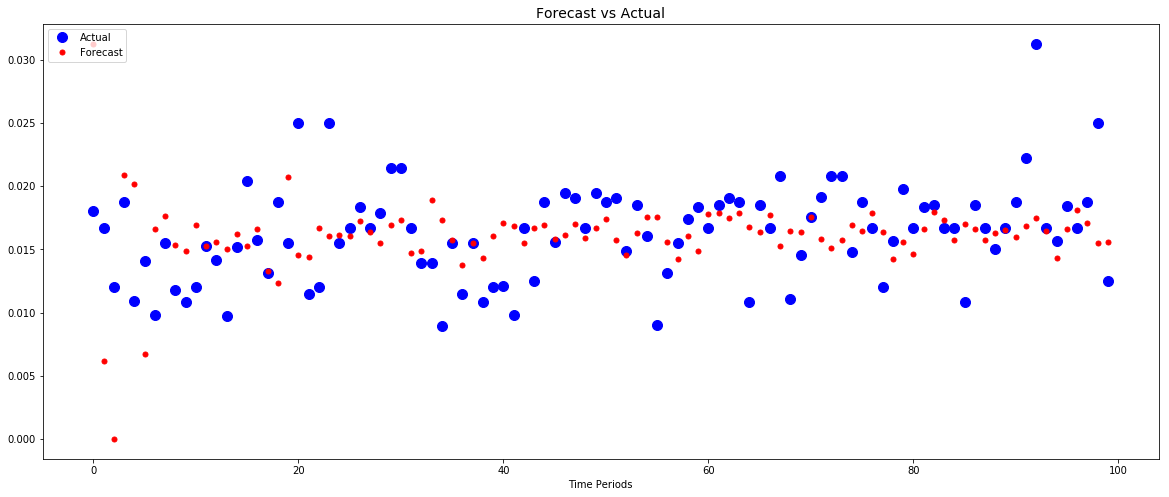

In [14]:
plt.figure(figsize=(20, 8))
plt.title('Forecast vs Actual', fontsize=14)
plt.plot(pd.Series(np.ravel(Y_test)), 'bo', markersize=10, label='Actual')
plt.plot(pd.Series(np.ravel(y_pred)), 'r.', markersize=10, label='Forecast')
plt.legend(loc='upper left')
plt.xlabel('Time Periods')
plt.show()